This tutorial will demonstrate how to pre-process single-cell raw UMI counts to generate expression matrices that can be used as input to cell-cell communication tools. We recommend the [quality control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) chapter in the Single-cell Best Practices book as a starting point for a detailed overview of QC and single-cell RNAseq analysis pipelines in general.

Here we will focus on:
1. Normalization
2. Inter-operability between R and python. 

We demonstrate a typical workflow using the popular single-cell analysis [Seurat](https://satijalab.org/seurat/index.html). We will use a [BALF COVID dataset](https://doi.org/10.1038/s41591-020-0901-9), which contains 12 samples associated with "Healthy Control", "Moderate", or "Severe" COVID contexts.

Details and caveats regarding [batch correction](https://www.nature.com/articles/s41592-018-0254-1), which removes technical variation while preserving biological variation between samples, can be viewed in the additional examples tutorial entitled "S1_Batch_Correction".

In [3]:
library(Seurat, quietly = T)
library(ggplot2, quietly = T)

# paths
data.path<-'/data/hratch/ccc_protocols/'

#### Loading

The 12 samples can be downloaded as .h5 files from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926). You can also download the cell metadata from [here](https://raw.githubusercontent.com/zhangzlab/covid_balf/master/all.cell.annotation.meta.txt)

We download these files directly in the proceeding cell:

In [4]:
covid.input.path<-paste0(data.path, 'raw/covid_balf/')

# download the metadata
metadata.link <- 'https://raw.githubusercontent.com/zhangzlab/covid_balf/master/all.cell.annotation.meta.txt'
cmd <- paste0('wget ', metadata.link, ' -O ', covid.input.path, 'metadata.txt')
system(cmd, ignore.stdout = T, ignore.stderr = T)

# download the expression data
sample.links <- c(
    'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4339nnn/GSM4339769/suppl/GSM4339769%5FC141%5Ffiltered%5Ffeature%5Fbc%5Fmatrix%2Eh5',
    'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4339nnn/GSM4339770/suppl/GSM4339770%5FC142%5Ffiltered%5Ffeature%5Fbc%5Fmatrix%2Eh5',
    'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4339nnn/GSM4339771/suppl/GSM4339771%5FC143%5Ffiltered%5Ffeature%5Fbc%5Fmatrix%2Eh5', 
    'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4339nnn/GSM4339772/suppl/GSM4339772%5FC144%5Ffiltered%5Ffeature%5Fbc%5Fmatrix%2Eh5', 
    'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4339nnn/GSM4339773/suppl/GSM4339773%5FC145%5Ffiltered%5Ffeature%5Fbc%5Fmatrix%2Eh5',
    'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4339nnn/GSM4339774/suppl/GSM4339774%5FC146%5Ffiltered%5Ffeature%5Fbc%5Fmatrix%2Eh5', 
    'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4475nnn/GSM4475048/suppl/GSM4475048%5FC51%5Ffiltered%5Ffeature%5Fbc%5Fmatrix%2Eh5', 
    'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4475nnn/GSM4475049/suppl/GSM4475049%5FC52%5Ffiltered%5Ffeature%5Fbc%5Fmatrix%2Eh5', 
    'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4475nnn/GSM4475050/suppl/GSM4475050%5FC100%5Ffiltered%5Ffeature%5Fbc%5Fmatrix%2Eh5', 
    'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4475nnn/GSM4475051/suppl/GSM4475051%5FC148%5Ffiltered%5Ffeature%5Fbc%5Fmatrix%2Eh5', 
    'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4475nnn/GSM4475052/suppl/GSM4475052%5FC149%5Ffiltered%5Ffeature%5Fbc%5Fmatrix%2Eh5',
    'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4475nnn/GSM4475053/suppl/GSM4475053%5FC152%5Ffiltered%5Ffeature%5Fbc%5Fmatrix%2Eh5'
    )

for (sl in sample.links){
    cmd <- paste0('wget ', sl, ' -P ', covid.input.path)
    system(cmd, ignore.stdout = T, ignore.stderr = T)
}

We can then format the downloaded files:

In [22]:
# format the metadata
md <- read.table(paste0(covid.input.path, 'metadata.txt'), header = T, row.names = 'ID')
colnames(md) = c('Sample.ID', 'sample_new', 'Condition', 'disease', 'hasnCoV', 'cluster', 'cell.type')

condition.map = c('Healthy.Control', 'Moderate COVID-19', 'Severe COVID-19')
names(condition.map) <- c('HC', 'M', 'S')
md['Condition'] <- unname(condition.map[md$Condition])
md$Condition <- factor(md$Condition, levels = c('Healthy.Control', 'Moderate COVID-19', 'Severe COVID-19'))

md<-md[md$Sample.ID != 'GSM3660650', ] # drop the non-scRNAseq dataset included in this file

sample.order<-c('C100', 'C144', 'C149', 'C51', 'C141', 'C145', 'C152', 'C143', 'C142', 'C146', 'C148', 'C52')
md$Sample.ID <- factor(md$Sample.ID, levels = sample.order)

md<-md[with(md, order(Sample.ID)), ]

In [40]:
balf.samples<-list()

suppressMessages({
    suppressWarnings({
        for (filename in list.files(covid.input.path)){
            if (endsWith(filename, '.h5')){
                sample<-unlist(strsplit(filename, '_'))[[2]]

                # subset and format metadata
                md.sample<-md[md$Sample.ID == sample,]
                rownames(md.sample) <- unname(sapply(rownames(md.sample), 
                                                   function(x) paste0(unlist(strsplit(x, '_'))[[1]], '-1')))
                # load the counts
                so <- Seurat::Read10X_h5(filename=paste0(covid.input.path, filename), unique.features=T)
                so <- so[, rownames(md.sample)] # only include cells present in the metadata

                # preprocess
                so <- CreateSeuratObject(counts=so, project=sample, meta.data=md.sample[c('Sample.ID', 'cluster', 'cell.type', 'Condition')])        
                balf.samples[[sample]] <- so
            }
        }        
    })
})

Merge into a single file

In [97]:
balf.samples<-balf.samples[sample.order]
covid_data<-merge(balf.samples[[1]], y = balf.samples[2:length(balf.samples)], 
                  project = "balf.covid")
covid_data<-covid_data[rownames(covid_data) != 'nCoV', ]

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [77]:
covid_data

An object of class Seurat 
33538 features across 63103 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)

In [50]:
head(covid_data@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,Sample.ID,cluster,cell.type,Condition
,<chr>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>
AAACCCACAGCTACAT-1_1,C100,3124,1377,C100,27,B,Healthy.Control
AAACCCATCCACGGGT-1_1,C100,1430,836,C100,23,Macrophages,Healthy.Control
AAACCCATCCCATTCG-1_1,C100,2342,1105,C100,6,T,Healthy.Control
AAACGAACAAACAGGC-1_1,C100,31378,4530,C100,10,Macrophages,Healthy.Control
AAACGAAGTCGCACAC-1_1,C100,12767,3409,C100,10,Macrophages,Healthy.Control
AAACGAAGTCTATGAC-1_1,C100,2198,1094,C100,9,T,Healthy.Control


#### Basic Filtering

Exclude cells that visually do not fall within the normal range of standard QC metrics (see [chapter](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html)) -- fraction of genes in a cell that are mitochondrial, number of unique genes, and total number of genes measured. 

In [98]:
# typically done in previous steps, but to align with python tutorials, we filter for genes/cells here
covid_data<-CreateSeuratObject(counts = covid_data@assays$RNA@counts, meta.data = covid_data@meta.data, 
                  min.cells = 3, min.features = 200, project = "balf.covid")

In [99]:
covid_data[["percent.mt"]] <- PercentageFeatureSet(covid_data, pattern = "^MT-")

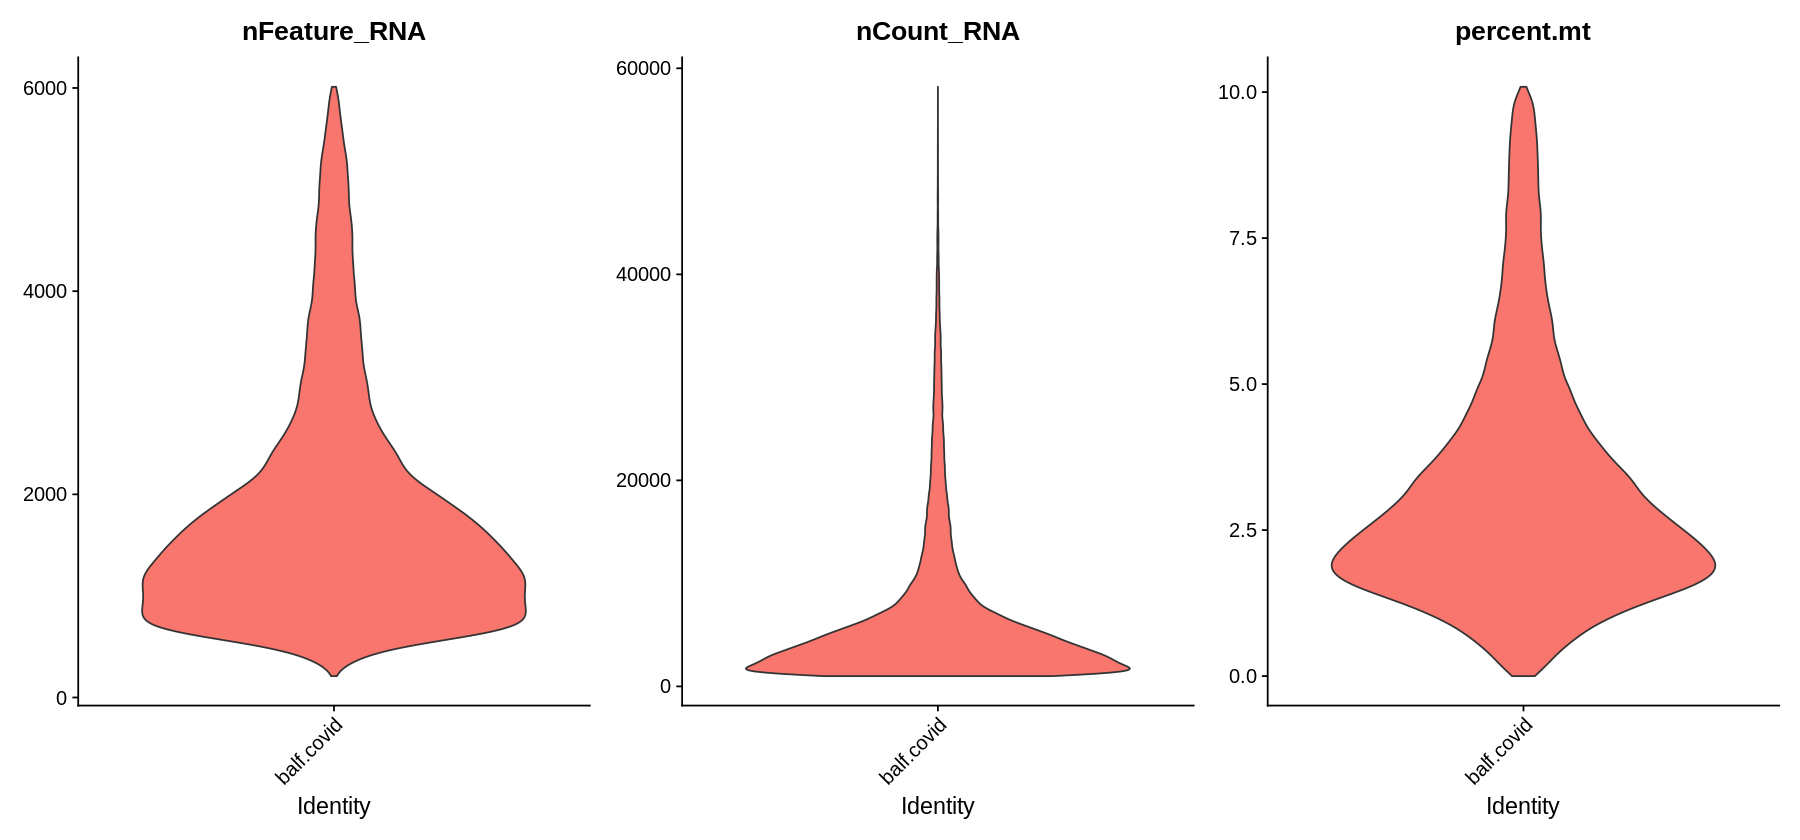

In [72]:
h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)
VlnPlot(covid_data, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)

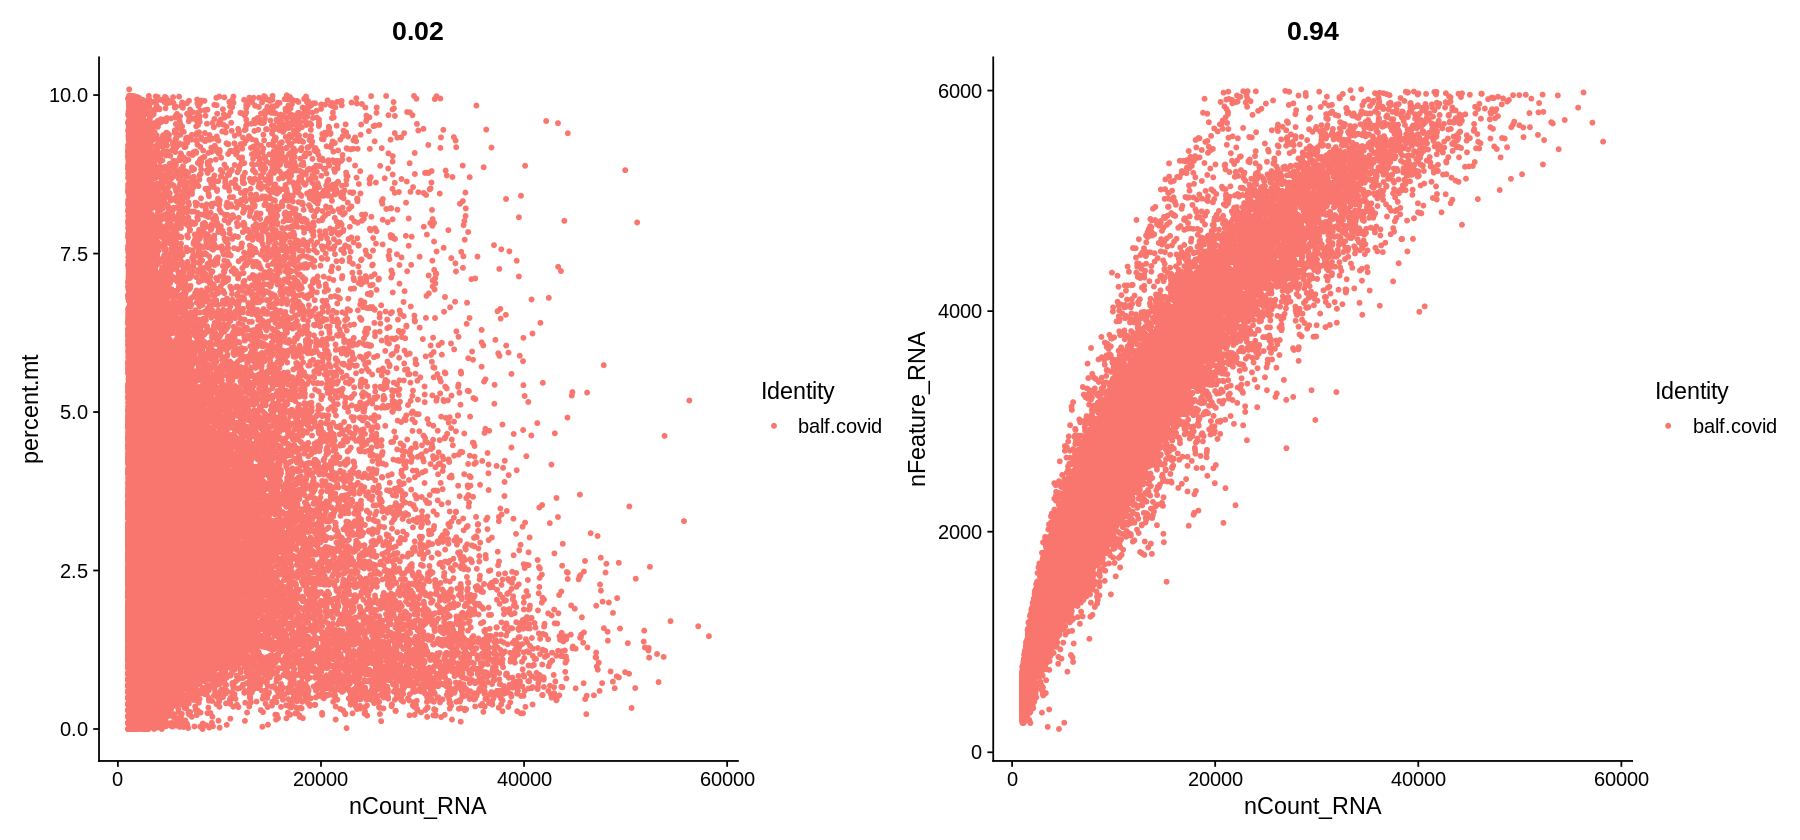

In [73]:
plot1 <- FeatureScatter(covid_data, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(covid_data, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [110]:
covid_data <- subset(covid_data, subset = nFeature_RNA < 5500)
covid_data <- subset(covid_data, subset = percent.mt < 15)


In [111]:
covid_data

An object of class Seurat 
24798 features across 62551 samples within 1 assay 
Active assay: RNA (24798 features, 0 variable features)

#### Normalize

For single-cell inference across sample and across cell types, most CCC tools require the library sizes to be comparable. We can use the scanpy function `sc.pp.normalize_total` to normalize the library sizes. This function divides each cell by the total counts per cell and multiplies by the median of the total counts per cell. Furthermore, we log1p-transform the data to make it more Gaussian-like, as this is a common assumption for the analyses downstream. Finally, such a normalization maintains non-negative counts, which is important for tensor decomposition.

In [112]:
covid_data <- NormalizeData(covid_data, normalization.method = "LogNormalize", scale.factor = 1e4)

In [149]:
ordered.genes<-sort(rownames(covid_data))
head(as.data.frame(covid_data@assays$RNA@data)[ordered.genes,])

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 11.6 GiB”


,AAACCCACAGCTACAT-1_1,AAACCCATCCACGGGT-1_1,AAACCCATCCCATTCG-1_1,AAACGAACAAACAGGC-1_1,AAACGAAGTCGCACAC-1_1,AAACGAAGTCTATGAC-1_1,AAACGAAGTGTAGTGG-1_1,AAACGCTGTCACGTGC-1_1,AAACGCTGTTGGAGGT-1_1,AAAGAACTCTAGAACC-1_1,⋯,TTTGTCAGTGTCAATC-1_12,TTTGTCAGTGTGAAAT-1_12,TTTGTCATCAGTTAGC-1_12,TTTGTCATCCAGTATG-1_12,TTTGTCATCCCTAATT-1_12,TTTGTCATCGATAGAA-1_12,TTTGTCATCGGAAATA-1_12,TTTGTCATCGGTCCGA-1_12,TTTGTCATCTCACATT-1_12,TTTGTCATCTCCAACC-1_12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,0,0,0,0.2766423,0.5784484,0,0,0,0.4703789,0.000000,⋯,0,0,0,1.753239,0,0,0,0,0.000000,0
A1BG-AS1,0,0,0,0.0000000,0.0000000,0,0,0,0.0000000,0.000000,⋯,0,0,0,0.000000,0,0,0,0,0.000000,0
A2M,0,0,0,0.8218827,0.0000000,0,0,0,0.0000000,1.614997,⋯,0,0,0,0.000000,0,0,0,0,1.695685,0
A2M-AS1,0,0,0,0.0000000,0.0000000,0,0,0,0.0000000,0.000000,⋯,0,0,0,0.000000,0,0,0,0,0.000000,0
A2ML1,0,0,0,0.0000000,0.0000000,0,0,0,0.0000000,0.000000,⋯,0,0,0,0.000000,0,0,0,0,0.000000,0
A2ML1-AS1,0,0,0,0.0000000,0.0000000,0,0,0,0.0000000,0.000000,⋯,0,0,0,0.000000,0,0,0,0,0.000000,0


Next, we can filter for highly variable genes (HVGs). Since CCC inference tools only consider a subset of the genes (those present in ligand-receptor databases), if you find yourself not identifying enough LR interactions, you may skip this step to input a larget gene list. 

**Currently, R and python diverge here, cannot get these two methods to output the same HVGs**

In [150]:
covid_data <- FindVariableFeatures(covid_data, selection.method = "vst", nfeatures = 2000)

#### Dimensionality Reduction

Centering and scaling data matrix

PC_ 1 
Positive:  TSPAN1, CD24, KRT8, FXYD3, KRT19, ELF3, MUC16, MUC4, TACSTD2, SLC44A4 
	   SMIM22, CLDN4, WFDC2, KRT18, SLPI, PERP, CYP4B1, TMC5, C19orf33, PLPP2 
	   CXCL17, AGR3, LMO7, EPCAM, AGR2, MAL2, PIGR, MYH14, CAPS, RSPH1 
Negative:  SERPINA1, GRN, CD68, CD74, MS4A7, S100A9, APOC1, ACP5, CTSL, CTSC 
	   C1QB, IFI30, C1QA, S100A8, APOE, MARCO, HLA-DRB5, HLA-DQB1, MSR1, SERPING1 
	   GPNMB, FABP5, C1QC, HLA-DQA1, FBP1, CFD, PLIN2, STXBP2, CD14, MS4A6A 
PC_ 2 
Positive:  C20orf85, C1orf194, C9orf24, RSPH1, FAM183A, SNTN, DYNLRB2, PIFO, C9orf116, LRRC46 
	   CCDC78, C11orf88, DNAH12, C5orf49, CFAP53, LRRIQ1, CFAP157, EFCAB1, ZMYND10, WDR38 
	   TEKT1, ROPN1L, DRC3, CFAP43, SAXO2, CAPSL, FAM92B, MORN5, C9orf135, CAPS 
Negative:  S100A16, GPRC5A, S100A14, ASS1, CEACAM6, TM4SF1, F3, AQP5, CEACAM5, KLK11 
	   KRT7, SERPINB3, SLC6A14, CXCL17, KRT17, PRSS23, MALL, FGFBP1, UPK1B, GABRP 
	   FAM3D, S100A2, BPIFB1, VSIG2, SFN, C19orf33, A4GALT, TACSTD2,

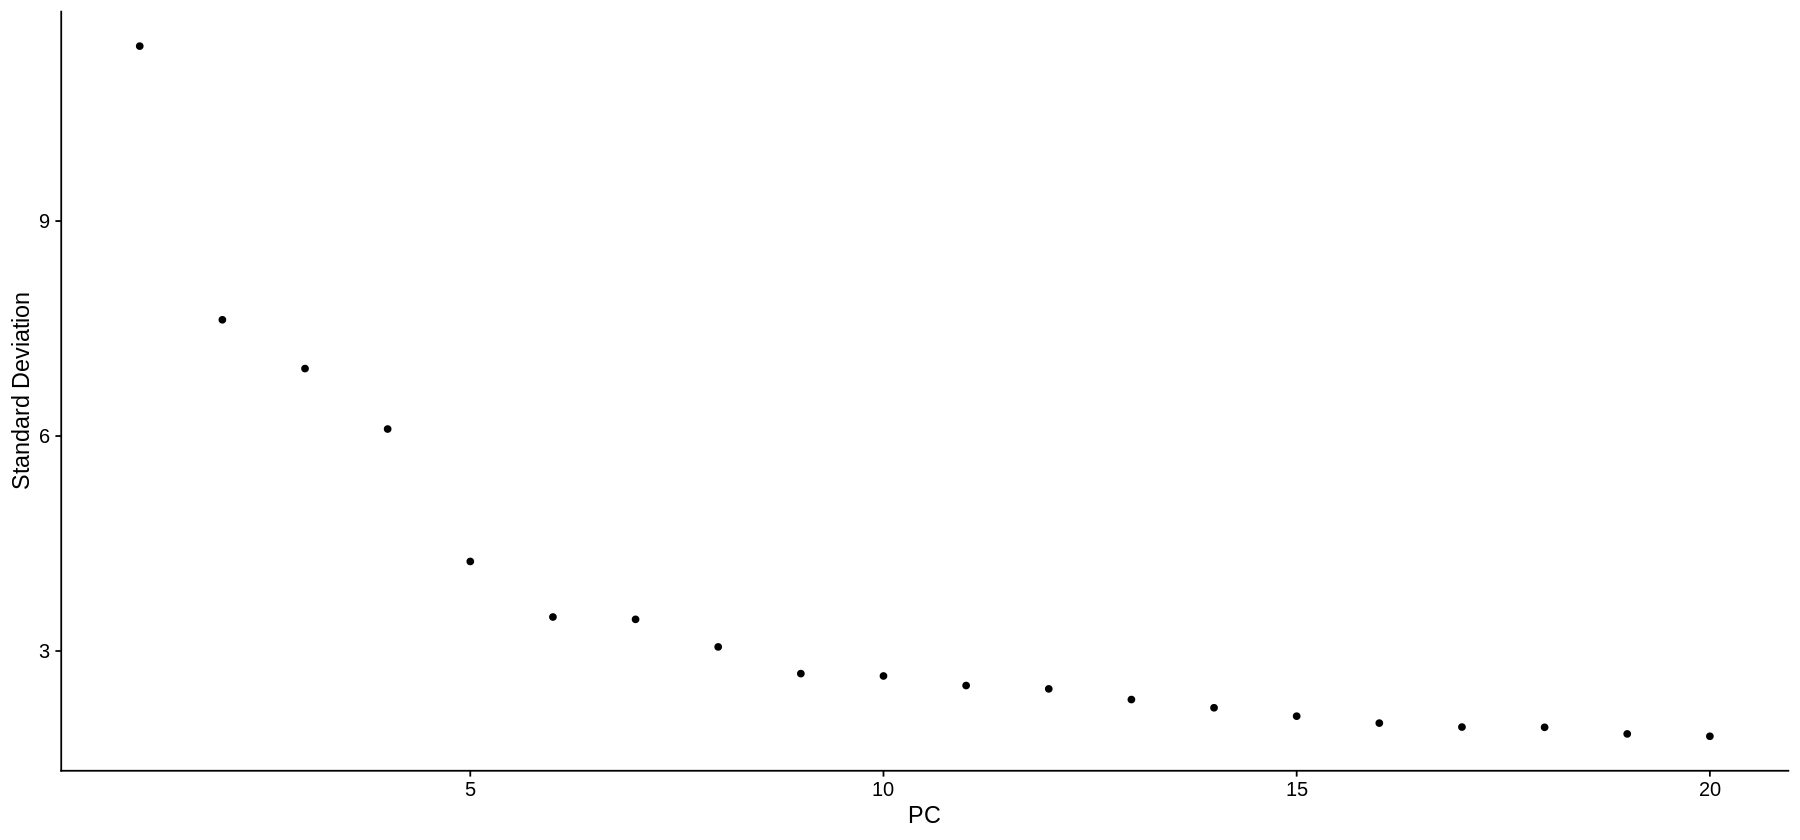

In [151]:
all.genes <- rownames(covid_data)
covid_data <- ScaleData(covid_data, features = all.genes)
covid_data <- RunPCA(covid_data, features = VariableFeatures(object = covid_data))
ElbowPlot(covid_data)

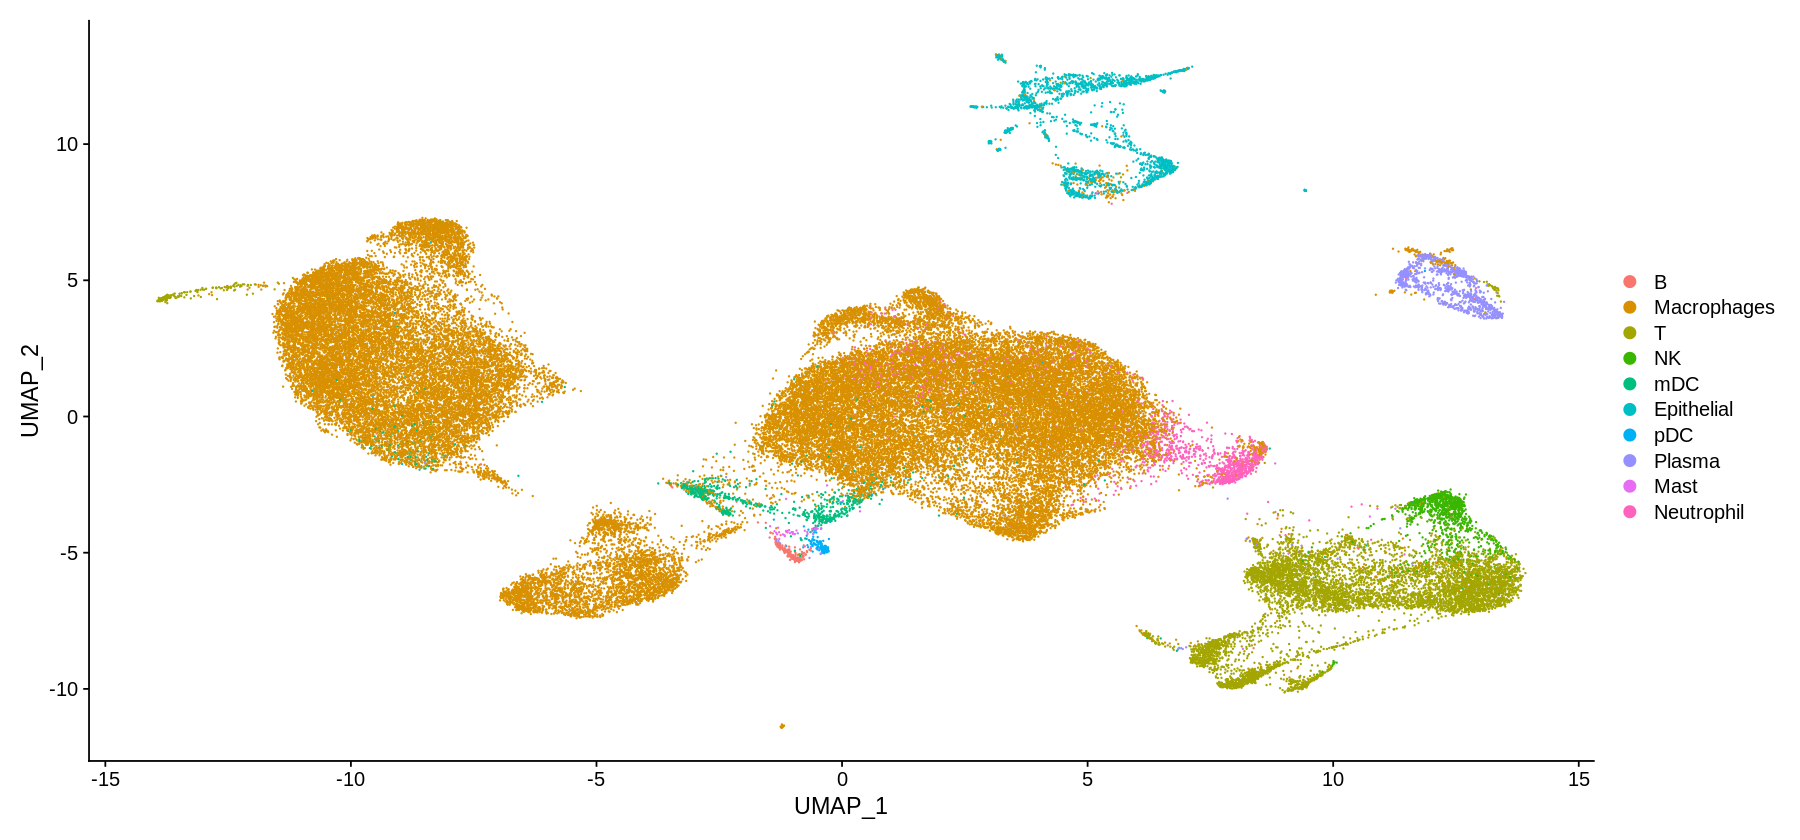

In [156]:
n.pcs<-20
covid_data <- FindNeighbors(covid_data, dims = 1:n.pcs)
covid_data <- RunUMAP(covid_data, dims = 1:n.pcs)
Idents(covid_data)<-'cell.type'
DimPlot(covid_data, reduction = "umap")

In [157]:
saveRDS(covid_data, paste0(data.path, 'interim/', 'covid_balf_norm.rds'))

# Interoperability

In [158]:
# interoperability
library(SeuratDisk, quietly = T)
library('reticulate')
anndata<-import('anndata')
library('Matrix')

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



## to Python

For use in Python, we can convert the Seurat object to an Anndata object using [SeuratDisk](https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html). The resultant h5ad file contains the same information as the AnnData object generated in the companion Python tutorial. See that tutorial for loading these saved files. 

In [160]:
file.name<-paste0(data.path, 'interim/', 'processed_fromR_toPython.h5Seurat')
SaveH5Seurat(covid_data, filename = file.name)
Convert(file.name, dest = "h5ad", overwrite = TRUE)

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding scale.data for RNA

Adding variable features for RNA

Adding feature-level metadata for RNA

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Validating h5Seurat file

Adding scale.data from RNA as X

Transfering meta.features to var

Adding data from RNA as raw

Transfering meta.features to raw/var

Transfering meta.data to obs

Adding dimensional reduction information for pca

Adding feature loadings for pca

Adding dimensional reduction information for umap

Adding RNA_snn as neighbors



## from Python

Here, we can load the expression matrices that were generated in the companion python script using AnnData and saved as h5ad files into Seurat:

In [163]:
adata_to_seurat<-function(adata){
    raw<-adata$raw$to_adata()
    raw.counts<-t(as.matrix(raw$X))
    rownames(raw.counts)<-rownames(raw$var)
    colnames(raw.counts)<-rownames(raw$obs)

    so<-CreateSeuratObject(counts=raw.counts, assay = 'RNA', meta.data = adata$obs)

    norm.counts<-t(as.matrix(adata$X))

    # whether HVGs were filtered for
    if (length(rownames(so)) == dim(norm.counts)[[1]]){
        rownames(norm.counts)<-rownames(so)
    }else{
        rownames(norm.counts)<-rownames(adata$var[adata$var$highly_variable,])
    }
    colnames(norm.counts)<-colnames(so)

    so@assays$RNA@data<-as(norm.counts, "dgCMatrix")
    so@assays$RNA@meta.features<-adata$var
    
    return(so)
}

In [193]:
adata<-anndata$read_h5ad(paste0(data.path, 'interim/', 'processed.h5ad'))
covid_data_fromPython<-adata_to_seurat(adata)